In [52]:
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import calendar
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from data.nela2017 import Nela2017
from rake_nltk import Rake

In [2]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lithplus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lithplus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
url = 'https://newsapi.org/v2/everything?'
api_key = "c31d9f572e5d47eeaae9d16463d0c921"

In [4]:
def get_articles(file):
    '''
    This is a helper function the extract articles from the newsapi dataset
    Input: file object
    Output: list
    ''' 


    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['title'] = file[i]['title']
        article_dict['author'] = file[i]['author']
        article_dict['source'] = file[i]['source']
        article_dict['description'] = file[i]['description']
        article_dict['content'] = file[i]['content']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['url'] = file[i]["url"]
        article_dict['photo_url'] = file[i]['urlToImage']
        article_results.append(article_dict)
    return article_results

def get_news_articles(source: str, topic: str):
    '''
    Returns the dataframe from newsource and topic
    Input: str,str
    Output: pd frame
    '''

    assert isinstance(source,str)
    assert isinstance(topic,str)

    
    parameters_headlines = {
    'q': topic,
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'domains' : format(source)  
    }

    # making the API call 
    response_headline = requests.get(url, params = parameters_headlines)
    response_json_headline = response_headline.json()
    responses = response_json_headline["articles"]
    # transforminf the data from JSON dictionary to a pandas data frame
    news_articles_df = pd.DataFrame(get_articles(responses))
    # printing the head to check the format and the working of the get_articles function
    return news_articles_df
def source_getter(df):
    source = []
    for source_dict in df['source']:
        source.append(source_dict['name'])
    df['source'] = source #append the source to the df

In [5]:
cnn_f = get_news_articles("cnn.com","biden")     #cnn covid frame
fox_f = get_news_articles("foxnews.com","biden") #fox covid frame

In [6]:
def get_senti_frame(frame = None, download = False):

    '''
    Returns a dataframe with sentiment scores extracted using nltk vader
    Input: pd frame, bool
    Output: pd frame
    '''
    
    assert isinstance(download,bool)

    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    if(download):nltk.download('vader_lexicon')
    sia = SIA()
    results = []
    titles = frame["title"]

    for line in titles:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    return df

In [7]:
cnn_sframe = get_senti_frame(cnn_f,True)
fox_sframe = get_senti_frame(fox_f,False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lithplus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
cnn_sframe.head()

,neg,neu,pos,compound,headline,label
0,0.000,0.764,0.236,0.5719,Biden set to celebrate 'Friendsgiving' with Fo...,1
1,0.000,0.781,0.219,0.4215,Biden will have an opportunity in his meeting ...,1
2,0.000,1.000,0.000,0.0000,Biden administration Covid vaccination data sh...,0
3,0.000,0.803,0.197,0.4019,Biden says 'shelves are going to be stocked' f...,1
4,0.208,0.615,0.177,-0.1027,Biden chastises GOP for targeting Republicans ...,0


In [9]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == 1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Biden set to celebrate 'Friendsgiving' with Fort Bragg service members and their families
Biden says 'shelves are going to be stocked' for the holiday season
Opinion: Democrats better build an ark


In [10]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == -1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Dems call for Biden to ban oil exports and tap emergency reserves
In pictures: Colin Powell's funeral
Construction halted on secret project at Chinese port in UAE after pressure from US, officials say


In [11]:
def plot(df,title:str):
    '''
      Given a sentiment frame, plot the sentiment
    '''
  
    assert isinstance(title,str)

    fig, ax = plt.subplots(figsize=(8, 8))

    counts = df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")
    ax.set_title(title)
    plt.show()

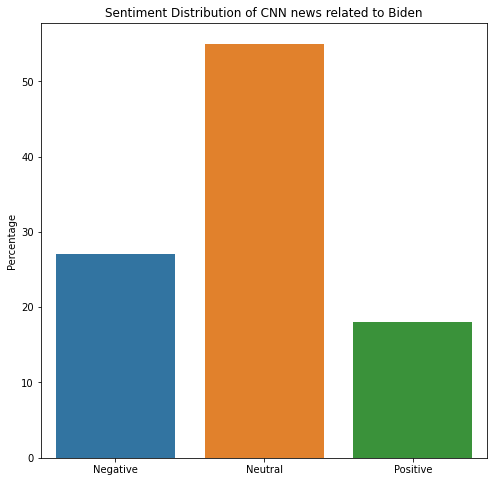

In [12]:
plot(cnn_sframe,"Sentiment Distribution of CNN news related to Biden")

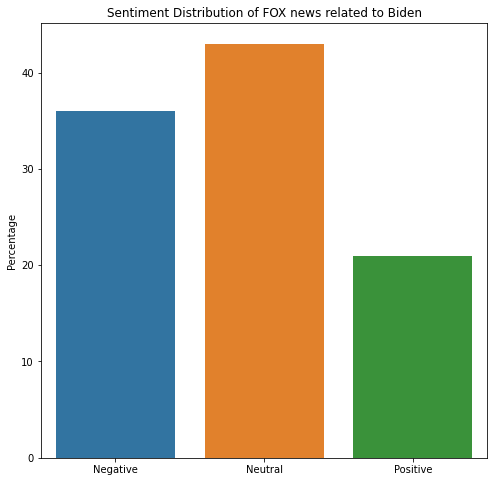

In [13]:
plot(fox_sframe,"Sentiment Distribution of FOX news related to Biden")

In [14]:
def get_word_freq(sframe,label,topk = 20,download = False):
    '''
    Returns the top words in the headlines given the label{1(pos), -1(negative)}
    Input: data frame,data frame, int, int, bool
          sframe: sentiment frame, df: news dataframe
    Output: list of dict 
    '''

    assert isinstance(label,int)
    assert isinstance(download,bool)

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    if download: nltk.download('stopwords')

    stop_words = stopwords.words('english')
    tokens = []


    pos_lines = list(sframe[sframe.label == label].headline)

    for line in pos_lines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    pos_freq = nltk.FreqDist(tokens)
    return pos_freq.most_common(topk) if topk is not None else pos_freq.most_common()


In [15]:
cnn_pos = get_word_freq(cnn_sframe,label = 1, topk = None,download = True)
print(cnn_pos[:20])
cnn_neg = get_word_freq(cnn_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('biden', 10), ('set', 2), ('mexico', 2), ('says', 2), ('trump', 2), ('positive', 2), ('covid', 2), ('19', 2), ('oil', 2), ('opinion', 2), ('us', 2), ('celebrate', 1), ('friendsgiving', 1), ('fort', 1), ('bragg', 1), ('service', 1), ('members', 1), ('families', 1), ('opportunity', 1), ('meeting', 1)]
[('biden', 11), ('us', 4), ('new', 4), ('house', 3), ('call', 2), ('ban', 2), ('oil', 2), ('high', 2), ('trump', 2), ('administration', 2), ('agenda', 2), ('record', 2), ('warns', 2), ('threats', 2), ('dems', 1), ('exports', 1), ('tap', 1), ('emergency', 1), ('reserves', 1), ('reached', 1)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lithplus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
fox_pos = get_word_freq(fox_sframe,label = 1, topk = None)
print(cnn_pos[:20])
fox_neg = get_word_freq(fox_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('biden', 10), ('set', 2), ('mexico', 2), ('says', 2), ('trump', 2), ('positive', 2), ('covid', 2), ('19', 2), ('oil', 2), ('opinion', 2), ('us', 2), ('celebrate', 1), ('friendsgiving', 1), ('fort', 1), ('bragg', 1), ('service', 1), ('members', 1), ('families', 1), ('opportunity', 1), ('meeting', 1)]
[('biden', 11), ('us', 4), ('new', 4), ('house', 3), ('call', 2), ('ban', 2), ('oil', 2), ('high', 2), ('trump', 2), ('administration', 2), ('agenda', 2), ('record', 2), ('warns', 2), ('threats', 2), ('dems', 1), ('exports', 1), ('tap', 1), ('emergency', 1), ('reserves', 1), ('reached', 1)]


In [17]:
pos_h_cnn = cnn_sframe[cnn_sframe["label"]==1]["headline"].tolist() 
pos_h_fox = cnn_sframe[fox_sframe["label"]==1]["headline"].tolist() 
neg_h_cnn = cnn_sframe[cnn_sframe["label"]==-1]["headline"].tolist() 
neg_h_fox = cnn_sframe[fox_sframe["label"]==-1]["headline"].tolist() 

In [18]:
pos_wc_cnn = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(pos_h_cnn))
neg_wc_cnn = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(neg_h_cnn))
pos_wc_fox = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(pos_h_fox))
neg_wc_fox = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(neg_h_fox))

In [19]:
def plot_word_cloud(wordcloud):
    '''
    plot a word cloud.
    Input: word cloud object
    Output: None
    '''
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

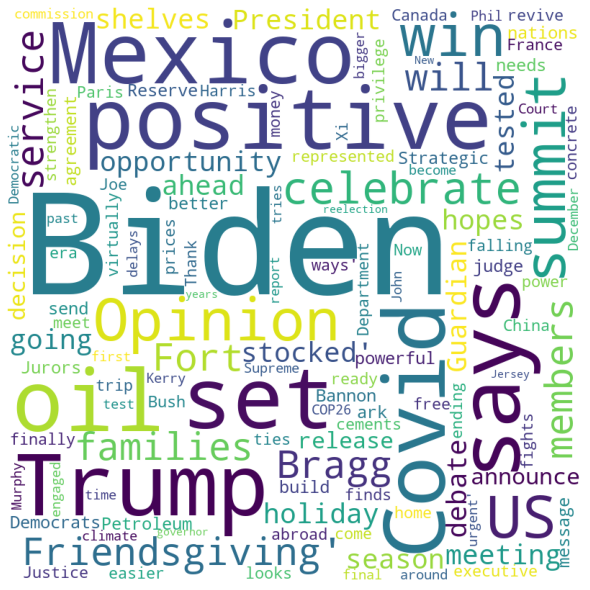

In [20]:
plot_word_cloud(pos_wc_cnn)

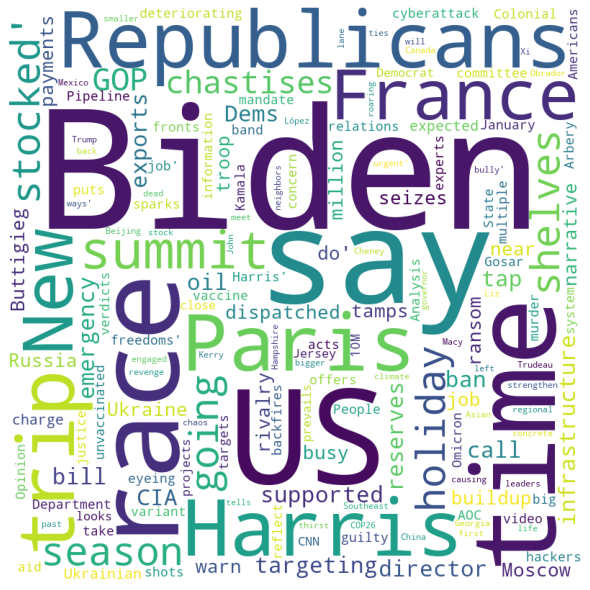

In [21]:
plot_word_cloud(pos_wc_fox)

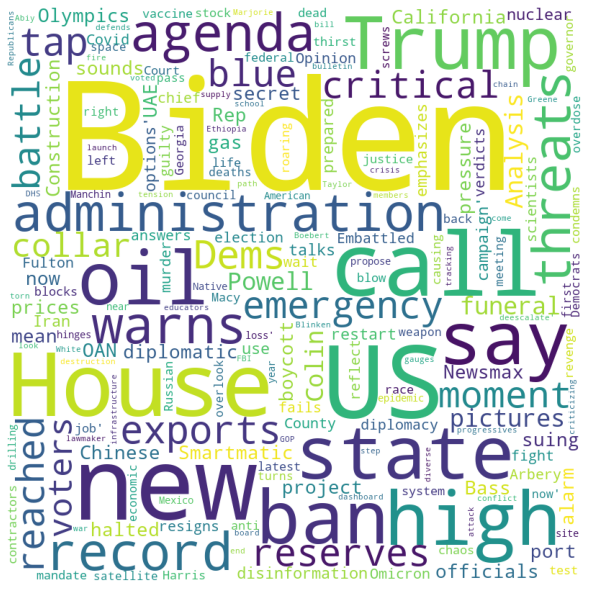

In [22]:
plot_word_cloud(neg_wc_cnn)

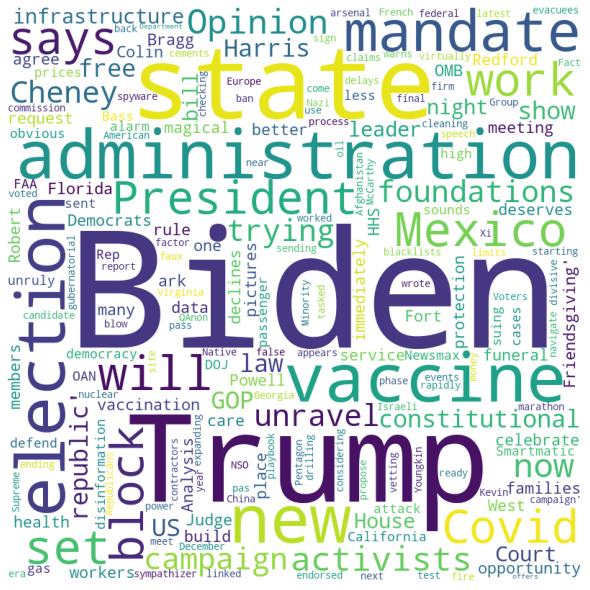

In [23]:
plot_word_cloud(neg_wc_fox)

In [24]:
cnn_covidf = get_news_articles("cnn.com","covid")     #cnn covid frame
fox_covidf = get_news_articles("foxnews.com","covid") #fox covid frame
source_getter(cnn_covidf)
source_getter(fox_covidf)
cnn_covidf['pub_date'] = pd.to_datetime(cnn_covidf['pub_date']).apply(lambda x: x.date())
fox_covidf['pub_date'] = pd.to_datetime(fox_covidf['pub_date']).apply(lambda x: x.date())

In [25]:
cnn_covidf['pub_date'].head()

0    2021-11-09
1    2021-11-04
2    2021-11-05
3    2021-11-18
4    2021-11-05
Name: pub_date, dtype: object

In [26]:
cnn_covidf.dropna(inplace=True)
cnn_covidf = cnn_covidf[~cnn_covidf['description'].isnull()]
# summarize the number of rows and columns in the dataset
print(cnn_covidf.isnull().sum())
print(cnn_covidf.shape)

title          0
author         0
source         0
description    0
content        0
pub_date       0
url            0
photo_url      0
dtype: int64
(94, 8)


In [27]:
fox_covidf.dropna(inplace=True)
fox_covidf = fox_covidf[~fox_covidf['description'].isnull()]
# summarize the number of rows and columns in the dataset
print(fox_covidf.isnull().sum())
print(fox_covidf.shape)

title          0
author         0
source         0
description    0
content        0
pub_date       0
url            0
photo_url      0
dtype: int64
(98, 8)


In [28]:
cnn_covidf['combined_text'] = cnn_covidf['title'].map(str) +" "+ cnn_covidf['content'].map(str) 
fox_covidf['combined_text'] = fox_covidf['title'].map(str) +" "+ fox_covidf['content'].map(str) 
cnn_covidf.head()

,title,author,source,description,content,pub_date,url,photo_url,combined_text
1,Indian homegrown Covid-19 shot wins WHO emerge...,Story by Reuters,CNN,The World Health Organization (WHO) said on We...,The World Health Organization (WHO) said on We...,2021-11-04,https://www.cnn.com/2021/11/03/asia/india-cova...,https://cdn.cnn.com/cnnnext/dam/assets/2111032...,Indian homegrown Covid-19 shot wins WHO emerge...
2,"Even if they get breakthrough infections, vacc...","Maggie Fox, CNN",CNN,"Even if they get a breakthrough infection, vac...",(CNN)Even if they get a breakthrough infection...,2021-11-05,https://www.cnn.com/2021/11/04/health/vaccines...,https://cdn.cnn.com/cnnnext/dam/assets/2111042...,"Even if they get breakthrough infections, vacc..."
3,How to prepare for another winter of Covid-19?...,"Katia Hetter, CNN",CNN,CNN Medical Analyst Dr. Leana Wen shares what ...,(CNN)Winter is almost here. After weeks of ste...,2021-11-18,https://www.cnn.com/2021/11/18/health/winter-c...,https://cdn.cnn.com/cnnnext/dam/assets/2111171...,How to prepare for another winter of Covid-19?...
5,US imposes travel restrictions over new Covid-...,"By <a href=""/profiles/fernando-alfonso-iii"">Fe...",CNN,"The US, European Union and other major destina...",Dutch health authorities said that the Omicron...,2021-11-28,https://www.cnn.com/world/live-news/new-covid-...,https://cdn.cnn.com/cnnnext/dam/assets/2111262...,US imposes travel restrictions over new Covid-...
6,Biden administration Covid vaccination data sh...,"Betsy Klein, CNN",CNN,The Biden administration's Office of Managemen...,(CNN)The Biden administration's Office of Mana...,2021-11-24,https://www.cnn.com/2021/11/24/politics/biden-...,https://cdn.cnn.com/cnnnext/dam/assets/2111191...,Biden administration Covid vaccination data sh...


In [29]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)
# function to remove the punctuations, apostrophe, special characters using regular expressions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text
# stop words are the words that convery little to no information about the actual content like the words:the, of, for etc
def remove_stopwords(word_tokens):
    filtered_sentence = [] 
    stop_words = stopwords.words('english')
    specific_words_list = ['char', 'u', 'hindustan', 'doj', 'washington'] 
    stop_words.extend(specific_words_list )
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    return filtered_sentence
# function for lemmatization 
def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return' '.join([lemmatizer.lemmatize(word) for word in x])

In [30]:
tokenizer = RegexpTokenizer(r'\w+')
def tokenize(x): 
    return tokenizer.tokenize(x)

In [31]:
cnn_covidf['combined_text'] = cnn_covidf['combined_text'].map(clean_text)
cnn_covidf['tokens'] = cnn_covidf['combined_text'].map(tokenize)
cnn_covidf['tokens'] = cnn_covidf['tokens'].map(remove_stopwords)
cnn_covidf['lems'] =cnn_covidf['tokens'].map(lemmatize)

In [32]:
fox_covidf['combined_text'] = fox_covidf['combined_text'].map(clean_text)
fox_covidf['tokens'] = fox_covidf['combined_text'].map(tokenize)
fox_covidf['tokens'] = fox_covidf['tokens'].map(remove_stopwords)
fox_covidf['lems'] =fox_covidf['tokens'].map(lemmatize)

In [36]:
cnn_covidf['keywords'] = ""
for index,row in cnn_covidf.iterrows():
    comb_text = row['combined_text']
    r = Rake()
    r.extract_keywords_from_text(comb_text)
    key_words_dict = r.get_word_degrees()
    row['keywords'] = list(key_words_dict.keys())
    
cnn_covidf['keywords'] = cnn_covidf['keywords'].map(remove_stopwords)
cnn_covidf['lems'] =cnn_covidf['keywords'].map(lemmatize)
cnn_covidf.head()

,title,author,source,description,content,pub_date,url,photo_url,combined_text,tokens,lems,keywords
1,Indian homegrown Covid-19 shot wins WHO emerge...,Story by Reuters,CNN,The World Health Organization (WHO) said on We...,The World Health Organization (WHO) said on We...,2021-11-04,https://www.cnn.com/2021/11/03/asia/india-cova...,https://cdn.cnn.com/cnnnext/dam/assets/2111032...,indian homegrown covid shot wins who emergenc...,"[indian, homegrown, covid, shot, wins, emergen...",indian homegrown covid shot win emergency use ...,"[indian, homegrown, covid, shot, wins, emergen..."
2,"Even if they get breakthrough infections, vacc...","Maggie Fox, CNN",CNN,"Even if they get a breakthrough infection, vac...",(CNN)Even if they get a breakthrough infection...,2021-11-05,https://www.cnn.com/2021/11/04/health/vaccines...,https://cdn.cnn.com/cnnnext/dam/assets/2111042...,even if they get breakthrough infections vacci...,"[even, get, breakthrough, infections, vaccinat...",even get breakthrough infection vaccinated peo...,"[even, get, breakthrough, infections, vaccinat..."
3,How to prepare for another winter of Covid-19?...,"Katia Hetter, CNN",CNN,CNN Medical Analyst Dr. Leana Wen shares what ...,(CNN)Winter is almost here. After weeks of ste...,2021-11-18,https://www.cnn.com/2021/11/18/health/winter-c...,https://cdn.cnn.com/cnnnext/dam/assets/2111171...,how to prepare for another winter of covid an...,"[prepare, another, winter, covid, expert, weig...",prepare another winter covid expert weight cnn...,"[prepare, another, winter, covid, expert, weig..."
5,US imposes travel restrictions over new Covid-...,"By <a href=""/profiles/fernando-alfonso-iii"">Fe...",CNN,"The US, European Union and other major destina...",Dutch health authorities said that the Omicron...,2021-11-28,https://www.cnn.com/world/live-news/new-covid-...,https://cdn.cnn.com/cnnnext/dam/assets/2111262...,us imposes travel restrictions over new covid ...,"[us, imposes, travel, restrictions, new, covid...",u imposes travel restriction new covid variant...,"[us, imposes, travel, restrictions, new, covid..."
6,Biden administration Covid vaccination data sh...,"Betsy Klein, CNN",CNN,The Biden administration's Office of Managemen...,(CNN)The Biden administration's Office of Mana...,2021-11-24,https://www.cnn.com/2021/11/24/politics/biden-...,https://cdn.cnn.com/cnnnext/dam/assets/2111191...,biden administration covid vaccination data sh...,"[biden, administration, covid, vaccination, da...",biden administration covid vaccination data sh...,"[biden, administration, covid, vaccination, da..."


In [37]:
def get_senti_frame(frame = None, download = False):

    '''
    Returns a dataframe with sentiment scores extracted using nltk vader
    Input: pd frame, bool
    Output: pd frame
    '''
    
    assert isinstance(download,bool)

    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    if(download):nltk.download('vader_lexicon')
    sia = SIA()
    results = []
    titles = frame["lems"]

    for line in titles:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    df['word_count'] = df['headline'].apply(lambda x: len(str(x).split()))
    return df

In [38]:
cnn_sframe = get_senti_frame(cnn_covidf,False)
fox_sframe = get_senti_frame(fox_covidf,False)

In [39]:
cnn_sframe.head()

,neg,neu,pos,compound,headline,label,word_count
0,0.083,0.635,0.283,0.743,indian homegrown covid shot win emergency use ...,1,24
1,0.130,0.787,0.083,-0.296,even get breakthrough infection vaccinated peo...,-1,22
2,0.000,1.000,0.000,0.000,prepare another winter covid expert weight cnn...,0,20
3,0.131,0.821,0.049,-0.296,u imposes travel restriction new covid variant...,-1,27
4,0.000,1.000,0.000,0.000,biden administration covid vaccination data sh...,0,27


In [40]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == 1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

indian homegrown covid shot win emergency use approval world health organization said wednesday granted drugmaker bharat biotech home grown vaccine listing paving way char
uk authorizes merck ridgeback biotherapeutics antiviral pill treat covid cnn medicine healthcare product regulatory agency said thursday authorized oral molnupiravir mild moderate char
christmas tradition keep going man survived covid two stroke heart attack cnn dale julie mark neighbor go decoration every year people come de moines iowa area see home covered festive lig char


In [41]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == -1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

even get breakthrough infection vaccinated people sick covid study show cnn infection two different team researcher reported thursday vaccine strongly prote char
nhl postpones upcoming new york islander game due covid outbreak cnn postponed least tuesday within team national hockey league announced saturday result addi char
american getting worst surge inflation priya fielding singh phd assistant professor family consumer study university utah author new book half eats untold story food ine char


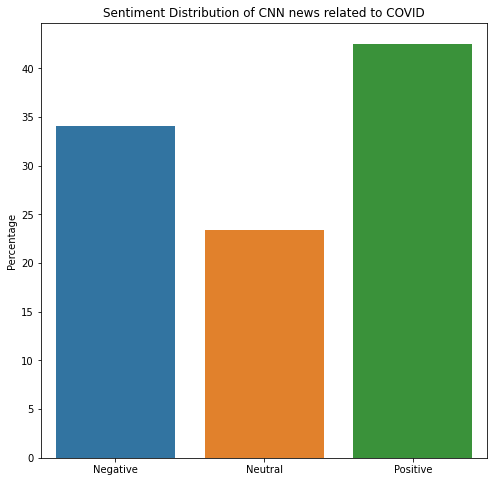

In [42]:
plot(cnn_sframe,"Sentiment Distribution of CNN news related to COVID")

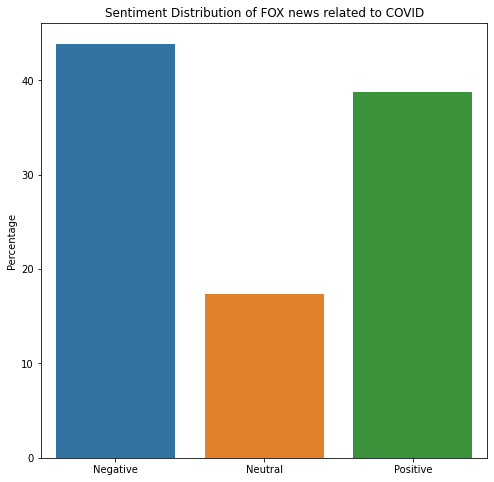

In [43]:
plot(fox_sframe,"Sentiment Distribution of FOX news related to COVID")

In [44]:
cnn_pos = get_word_freq(cnn_sframe,label = 1, topk = None)
print(cnn_pos[:20])
cnn_neg = get_word_freq(cnn_sframe,label = -1, topk = None)
print(cnn_neg[:20])
fox_pos = get_word_freq(fox_sframe,label = 1, topk = None)
print(cnn_pos[:20])
fox_neg = get_word_freq(fox_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('char', 40), ('cnn', 30), ('covid', 16), ('year', 10), ('opinion', 9), ('vaccine', 7), ('pandemic', 7), ('holiday', 7), ('new', 7), ('first', 7), ('u', 6), ('book', 6), ('shot', 5), ('world', 5), ('way', 5), ('state', 5), ('president', 5), ('author', 5), ('week', 5), ('win', 4)]
[('char', 32), ('cnn', 28), ('covid', 12), ('new', 11), ('vaccine', 6), ('u', 6), ('variant', 6), ('get', 5), ('omicron', 5), ('time', 5), ('people', 4), ('travel', 4), ('south', 4), ('york', 4), ('say', 4), ('american', 4), ('china', 4), ('world', 4), ('president', 4), ('infection', 3)]
[('char', 40), ('cnn', 30), ('covid', 16), ('year', 10), ('opinion', 9), ('vaccine', 7), ('pandemic', 7), ('holiday', 7), ('new', 7), ('first', 7), ('u', 6), ('book', 6), ('shot', 5), ('world', 5), ('way', 5), ('state', 5), ('president', 5), ('author', 5), ('week', 5), ('win', 4)]
[('char', 32), ('cnn', 28), ('covid', 12), ('new', 11), ('vaccine', 6), ('u', 6), ('variant', 6), ('get', 5), ('omicron', 5), ('time', 5), ('people

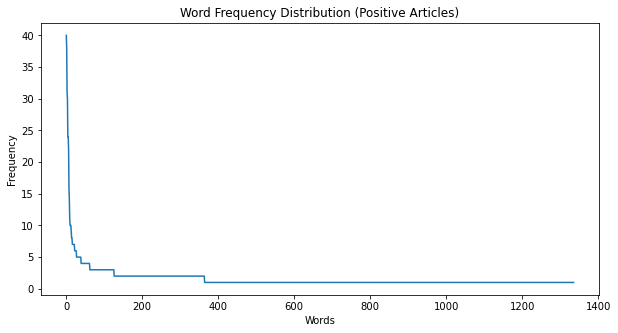

In [45]:
positive = sorted(fox_pos + cnn_pos,key = lambda i: -i[1])
y_val = [x[1] for x in positive]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive Articles)")
plt.show()

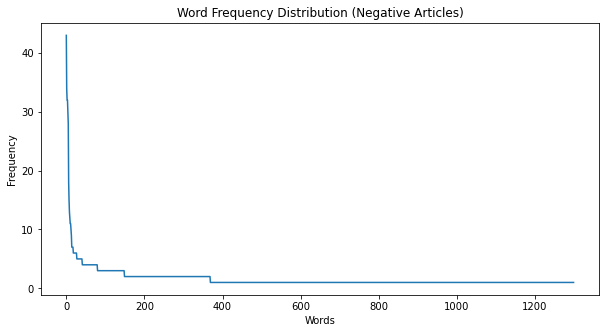

In [46]:
negative =sorted(fox_neg + cnn_neg,key = lambda i: -i[1])
y_val = [x[1] for x in negative]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative Articles)")
plt.show()

In [53]:
ROOT = os.getcwd() + "/NELA2017"
nela = Nela2017(ROOT)

In [54]:
# extract articles, takes about 20-25 seconds on my computer
articles = nela.list()

NotADirectoryError: [Errno 20] Not a directory: '/Users/lithplus/Documents/news-bias-analysis/NELA2017/articles/7_October/2017-10-08/.DS_Store'